## American options pricing
In this notebook, we will present different methods for pricing american options.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class AmericanOptions:
    def __init__(self, r, sigma):
        self.sigma = sigma
        self.r = r

    def __call__(self, T, n, S0):
        dt = T / n  # Time step
        Z = np.random.normal(0, 1, n)  # Brownian motion increments
        S = [S0]  # Store stock prices
        
        for i in range(n):  # Iterate n times
            S_next = S[-1] * np.exp((self.r - 0.5 * self.sigma**2) * dt + self.sigma * np.sqrt(dt) * Z[i])
            S.append(S_next)
        
        return np.array(S)  # Convert list to numpy array



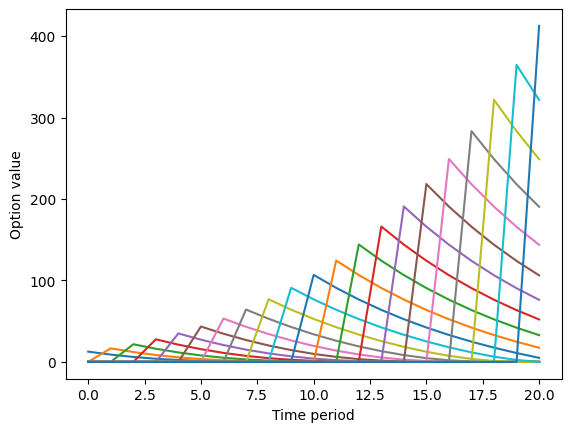

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def binomial_option_values(S, X, r, T, N, sigma, option_type):
    """
    S: current price of the underlying asset
    X: exercise price of the option
    r: risk-free interest rate
    T: time to expiration of the option (in years)
    N: number of time periods in the binomial model
    option_type: "call" or "put"
    """
    dt = T/N
    u = np.exp(sigma * np.sqrt(dt))
    d = 1/u
    p = (np.exp(r*dt) - d)/(u - d)
    values = np.zeros((N+1, N+1))
    
    for j in range(N+1):
        values[N][j] = max(0, (S*u**j*d**(N-j) - X))
        
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            values[i][j] = np.exp(-r*dt)*(p*values[i+1][j+1] + (1-p)*values[i+1][j])
            
    return values

# Example usage:
S = 50
X = 45
r = 0.05
T = 0.5
N = 20
sigma = 0.7
option_type = "call"

option_values = binomial_option_values(S, X, r, T, N, sigma, option_type)

# Plot the option values over time
plt.plot(option_values)
plt.xlabel("Time period")
plt.ylabel("Option value")
plt.show()

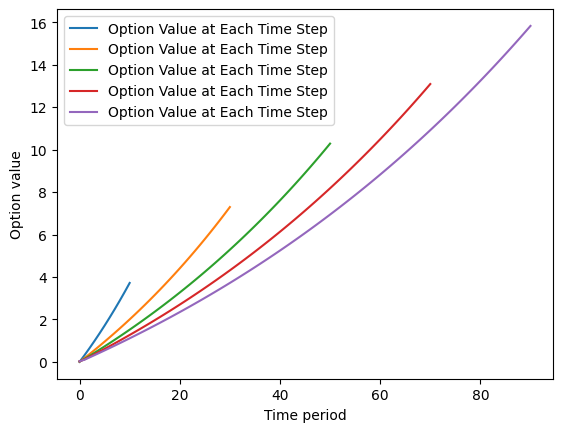

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def pay(K, N, a, b, r, S=1):
    values = np.zeros((N+1, N+1))
    
    # Base case: Compute final step values
    for i in range(N+1):
        x_val = S * (1 + a)**i * (1 + b)**(N - i)
        values[N][i] = max(-K + x_val, 0)
    
    p = (r - a) / (b - a)  # Corrected risk-neutral probability
    
    # Fill DP table iteratively
    for i in range(N-1, -1, -1):
        for j in range(i+1):
            x_val = S * (1 + a)**j * (1 + b)**(i - j)
            expected = (p * values[i+1][j+1] + (1 - p) * values[i+1][j]) / (1 + r)
            values[i][j] = max(max(-K + x_val, 0), expected)
    
    return values

def binomial(sigma, T, N, R, K, S=1):  # Added S as parameter
    dt = T / N
    r = R * dt  # Per-period interest rate
    a = np.exp(-sigma * np.sqrt(dt)) - 1
    b = np.exp(sigma * np.sqrt(dt)) - 1
    return pay(K, N, a, b, r, S)  # Pass S to pay

# Parameters
S = 10
X = 10
r = 0.5
T = 1
N = 2000
sigma = 0.1
for N in range(10,100,20) :
    option_values = binomial(sigma=sigma, T=T, N=N, R=r, K=X, S=S)  # Pass S here
    # Plotting
    plt.plot(option_values[:, 0], label="Option Value at Each Time Step")
    plt.xlabel("Time period")
    plt.ylabel("Option value")
    plt.legend()
plt.show()

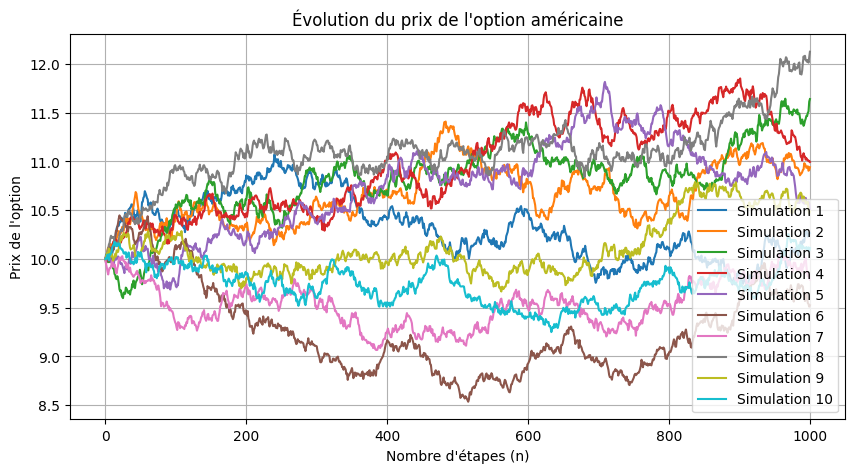

In [5]:
import matplotlib.pyplot as plt

N = 10
n = 1000

plt.figure(figsize=(10, 5))

for _ in range(N):
    option = AmericanOptions(r=0.05, sigma=0.1)
    prices = option(T=1, n=n, S0=10)
    plt.plot(range(n + 1), prices, label=f"Simulation {_ + 1}")

# Ajout de titres et labels
plt.title("Évolution du prix de l'option américaine")
plt.xlabel("Nombre d'étapes (n)")
plt.ylabel("Prix de l'option")
plt.legend()
plt.grid(True)

plt.show()


In [6]:
def payoff(S,K) :
    return np.maximum(K-S,0)

In [7]:
N = 1000
n = 1000
S0 = 10
r = 0.05
sigma = 0.1
T = 1

simulations = []  # Fixed the typo in "siumlations"

for _ in range(N):
    option = AmericanOptions(r=r, sigma=sigma)
    prices = option(T=T, n=n, S0=S0)
    simulations.append(prices)

# Convert the list to a NumPy array
S= np.array(simulations)

print(S.shape)  # This will print (1000, ?) depending on prices shape


(1000, 1001)


In [8]:
V = np.zeros((N,n+1))
K = S0
V[:, -1] = payoff(S[:, -1], K)


1000
1000


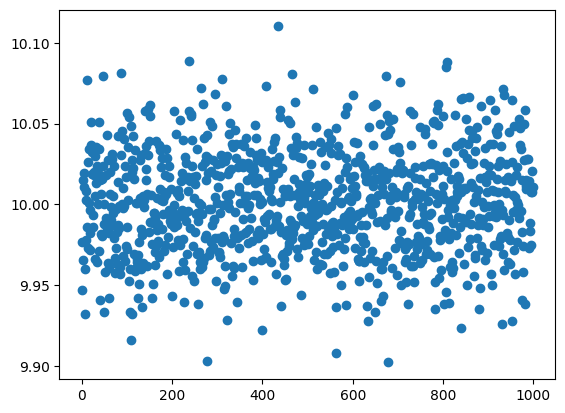

In [9]:
S1 = S[:,1]
len(S1)
print(len(S1))
print(n)
plt.scatter(range(0,N),S1)
plt.show()

In [10]:
dt = T/n
# Backward Induction
for i in range(n-1, 0, -1):  # Iterate backwards from the second last time step
    S_i = S[:, i]
    V_i_1 = V[:, i+1]
    V_i = np.exp(-r * dt) * V_i_1  # Discounted future value
    
    # Fit continuation value using Laguerre polynomials
    fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=5)  # Choose degree 3
    # Compute continuation value
    continuation_value = fit(S_i)

    # Immediate exercise value
    exercise_value = payoff(S_i, K)

    # Apply early exercise condition
    V[:, i] = np.where(exercise_value > continuation_value, exercise_value, V_i)

# Compute option price (discounted expectation)
option_price = np.exp(-r * dt) * np.mean(V[:, 1])

print(f"American Option Price: {option_price:.4f}")


American Option Price: 0.2386


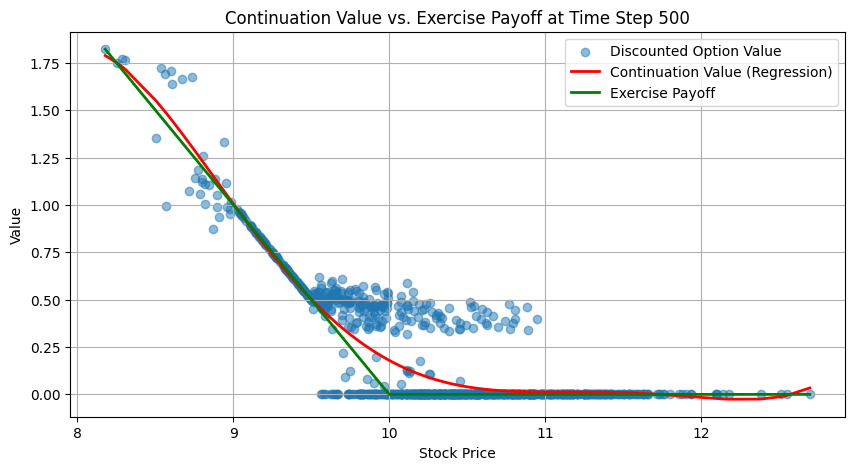

In [11]:
i = n // 2  # Pick a mid-time step
S_i = S[:, i]
V_i = V[:, i]
fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=5)  # Regression fit
continuation_value = fit(S_i)
exercise_value = payoff(S_i, K)

plt.figure(figsize=(10, 5))
plt.scatter(S_i, V_i, label="Discounted Option Value", alpha=0.5)
plt.plot(np.sort(S_i), fit(np.sort(S_i)), label="Continuation Value (Regression)", color="red", linewidth=2)
plt.plot(np.sort(S_i), payoff(np.sort(S_i), K), label="Exercise Payoff", color="green", linewidth=2)
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.title(f"Continuation Value vs. Exercise Payoff at Time Step {i}")
plt.legend()
plt.grid()
plt.show()


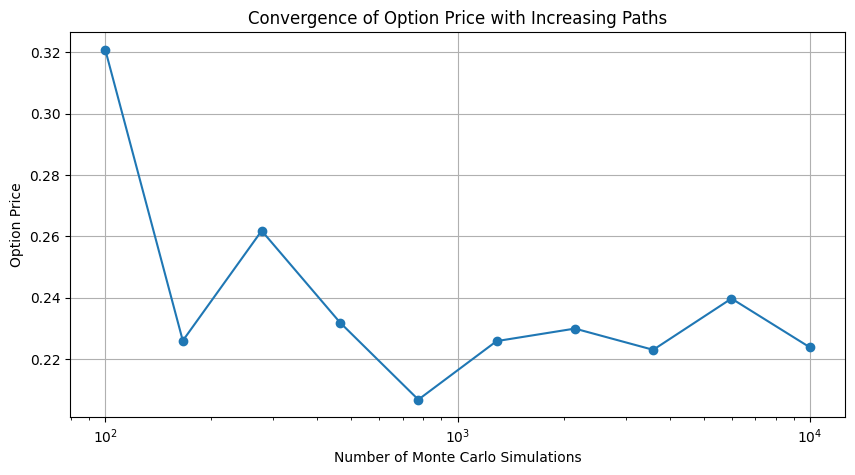

In [12]:
num_paths = np.logspace(2, 4, 10, dtype=int)  # Vary number of paths
option_prices = []

for N_test in num_paths:
    S_test = np.zeros((N_test, n+1))
    S_test[:, 0] = S0
    for i in range(1, n+1):
        Z = np.random.normal(size=N_test)
        S_test[:, i] = S_test[:, i-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    
    V_test = np.zeros_like(S_test)
    V_test[:, -1] = payoff(S_test[:, -1], K)

    for i in range(n-1, 0, -1):
        S_i = S_test[:, i]
        V_i = np.exp(-r * dt) * V_test[:, i+1]
        fit = np.polynomial.Laguerre.fit(S_i, V_i, deg=3)
        continuation_value = fit(S_i)
        V_test[:, i] = np.where(payoff(S_i, K) > continuation_value, payoff(S_i, K), V_i)

    option_price = np.exp(-r * dt) * np.mean(V_test[:, 1])
    option_prices.append(option_price)

plt.figure(figsize=(10, 5))
plt.plot(num_paths, option_prices, marker='o', linestyle='-')
plt.xscale("log")
plt.xlabel("Number of Monte Carlo Simulations")
plt.ylabel("Option Price")
plt.title("Convergence of Option Price with Increasing Paths")
plt.grid()
plt.show()


In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()  
        self.branch1 = nn.Sequential(nn.Linear(1, 10), nn.ReLU())  
        self.branch2 = nn.Sequential(nn.Linear(10, 20), nn.ReLU())  
        self.branch3 = nn.Sequential(nn.Linear(20, 1)) 

    def forward(self, x):
        x = self.branch1(x)
        x = self.branch2(x)
        x = self.branch3(x)
        return x
model = Model()

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim

def train_model(model, X_train, y_train, epochs=20, learning_rate=0.01):

    criterion = nn.MSELoss()  # Mean Squared Error Loss for regression
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        
        optimizer.zero_grad()  # Clear previous gradients
        y_pred = model(X_train)  # Forward pass
        loss = criterion(y_pred, y_train)  # Compute loss
        
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights



In [15]:
dt = T / n  # Time step size


for i in range(n - 1, 0, -1):  # Iterate backwards from the second last time step
    S_i = S[:, i]  # Shape (1000,)
    V_i_1 = V[:, i + 1]  # Shape (1000,)
    model = Model()
    # Discounted future value
    V_i = np.exp(-r * dt) * V_i_1  # Shape (1000,)

    # Convert NumPy arrays to PyTorch tensors (reshaped to 2D: (1000, 1))
    S_i_tensor = torch.tensor(S_i, dtype=torch.float32).unsqueeze(1)  # Shape (1000, 1)
    V_i_tensor = torch.tensor(V_i, dtype=torch.float32).unsqueeze(1)  # Shape (1000, 1)

    # Train the model
    train_model(model, S_i_tensor, V_i_tensor)

    # Compute continuation value
    continuation_value = model(S_i_tensor)  # Now correctly passing a tensor

    # Immediate exercise value
    exercise_value = payoff(S_i, K)  # Should return a NumPy array of shape (1000,)

    # Convert to PyTorch tensor and reshape
    exercise_value_tensor = torch.tensor(exercise_value, dtype=torch.float32).unsqueeze(1)

    # Apply early exercise condition and store results back into NumPy array
    V[:, i] = torch.where(exercise_value_tensor > continuation_value, exercise_value_tensor, V_i_tensor).squeeze().numpy()

# Compute option price (discounted expectation)
option_price = np.exp(-r * dt) * np.mean(V[:, 1])

print(f"American Option Price: {option_price:.4f}")


American Option Price: 0.0235


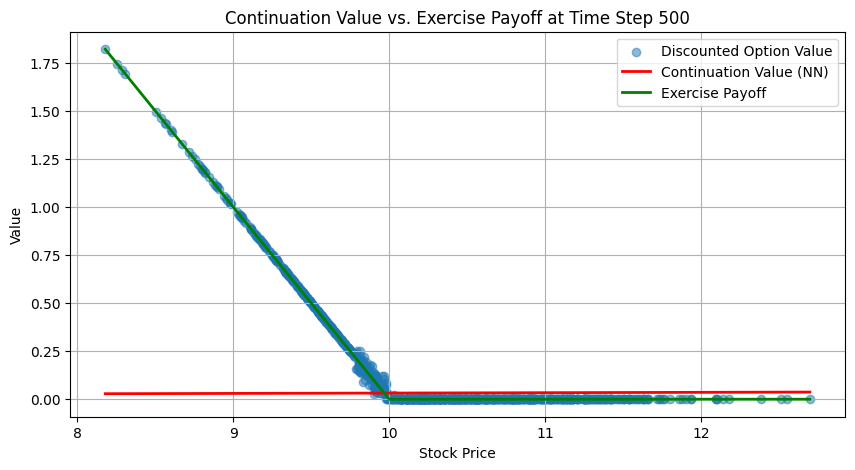

In [16]:
import torch
import matplotlib.pyplot as plt

# Pick a mid-time step
i = n // 2  
S_i = S[:, i]
V_i = V[:, i]

# Convert to PyTorch tensors
S_i_tensor = torch.tensor(S_i, dtype=torch.float32).view(-1, 1)

# Use trained NN model to predict continuation value
with torch.no_grad():
    continuation_value = model(S_i_tensor).numpy().flatten()

exercise_value = payoff(S_i, K)

# Plot results
plt.figure(figsize=(10, 5))
plt.scatter(S_i, V_i, label="Discounted Option Value", alpha=0.5)
plt.plot(np.sort(S_i), np.sort(continuation_value), label="Continuation Value (NN)", color="red", linewidth=2)
plt.plot(np.sort(S_i), payoff(np.sort(S_i), K), label="Exercise Payoff", color="green", linewidth=2)
plt.xlabel("Stock Price")
plt.ylabel("Value")
plt.title(f"Continuation Value vs. Exercise Payoff at Time Step {i}")
plt.legend()
plt.grid()
plt.show()


In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset, random_split

# Black-Scholes Call Price Calculation
def black_scholes(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price

# Generate Synthetic Data
np.random.seed(42)
num_samples = 100000
S = np.random.uniform(50, 150, num_samples)
K = np.random.uniform(50, 150, num_samples)
T = np.random.uniform(0.1, 2.0, num_samples)
r = np.random.uniform(0.01, 0.10, num_samples)
sigma = np.random.uniform(0.1, 0.5, num_samples)
call_prices = black_scholes(S, K, T, r, sigma)

# Combine features and normalize
X = np.column_stack((S, K, T, r, sigma))
y = call_prices.reshape(-1, 1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Split into train/test sets
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the Neural Network
class PricingNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(5, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1)
        )
    
    def forward(self, x):
        return self.net(x)

# Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PricingNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
    
    # Validation
    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
    
    # Print losses
    train_loss = train_loss / len(train_loader.dataset)
    test_loss = test_loss / len(test_loader.dataset)
    print(f"Epoch {epoch+1}/{num_epochs} | Train Loss: {train_loss:.6f} | Test Loss: {test_loss:.6f}")

# Example Prediction
model.eval()
sample_input = torch.tensor(scaler.transform([[100.0, 100.0, 1.0, 0.05, 0.2]]), dtype=torch.float32).to(device)
predicted_price = model(sample_input).item()
actual_price = black_scholes(100.0, 100.0, 1.0, 0.05, 0.2)

print(f"\nPredicted Price: {predicted_price:.4f}")
print(f"Black-Scholes Price: {actual_price:.4f}")

Epoch 1/10 | Train Loss: 19.684312 | Test Loss: 0.093932
Epoch 2/10 | Train Loss: 0.071059 | Test Loss: 0.094372
Epoch 3/10 | Train Loss: 0.061685 | Test Loss: 0.111946
Epoch 4/10 | Train Loss: 0.063792 | Test Loss: 0.029226
Epoch 5/10 | Train Loss: 0.055937 | Test Loss: 0.101246
Epoch 6/10 | Train Loss: 0.061950 | Test Loss: 0.063003
Epoch 7/10 | Train Loss: 0.053181 | Test Loss: 0.023857
Epoch 8/10 | Train Loss: 0.042953 | Test Loss: 0.023205
Epoch 9/10 | Train Loss: 0.044003 | Test Loss: 0.021196
Epoch 10/10 | Train Loss: 0.042615 | Test Loss: 0.022113

Predicted Price: 10.3631
Black-Scholes Price: 10.4506
